In [180]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 05a
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**

In [181]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,  classification_report
from sklearn.model_selection import train_test_split

from collections.abc import Callable
from typing import Literal

# Changes-----------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Changes-----------------------------------
 
%matplotlib inline

In [182]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 2001 # number of epochs
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

In [183]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [184]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

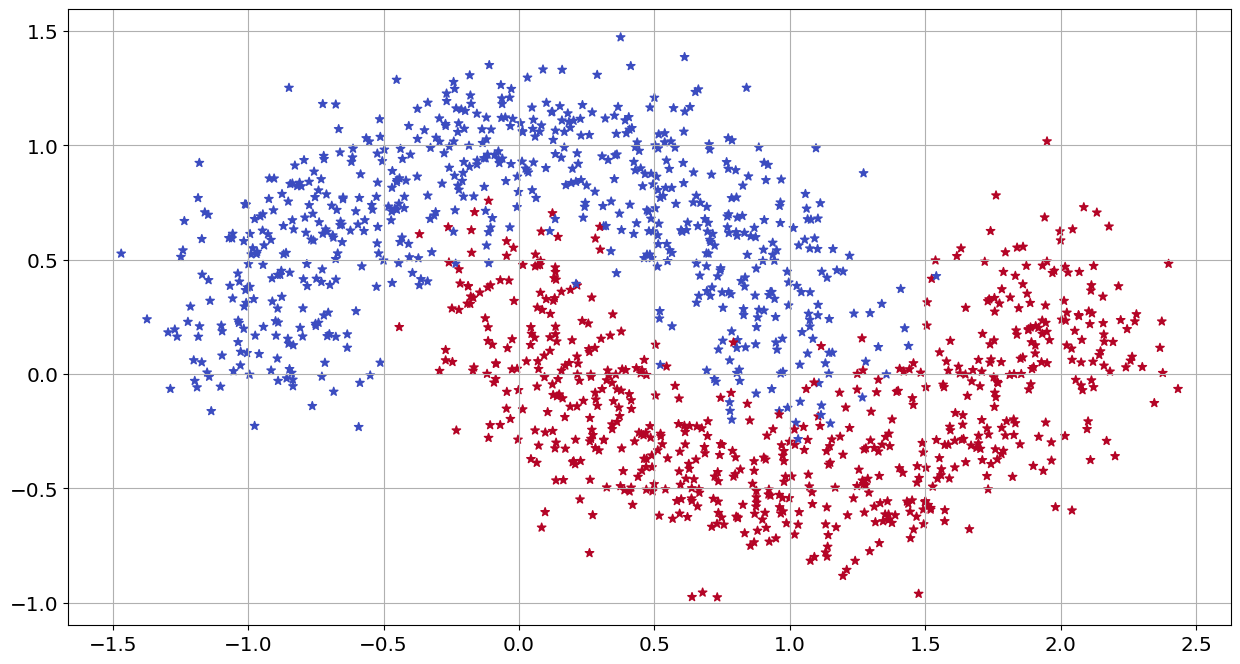

In [185]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP)

plt.grid()

In [186]:
###############################
### Make it multi-class data ###
###############################

y = pd.get_dummies(y).to_numpy()
y

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [187]:
y.shape

(1280, 2)

In [188]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


In [189]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [190]:
nn_input_dim = X_train.shape[1]
nn_hdim = 4
nn_output_dim = 2

hist = {}
nn_input_dim, nn_hdim, nn_output_dim

(2, 4, 2)

In [191]:
class Model(nn.Module):
    def __init__(self, input_dim, nn_hdim, nn_output_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, nn_hdim)
        self.layer2 = nn.Linear(nn_hdim, nn_output_dim)

    def forward(self, x):
        x = F.tanh(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=1)
        return x

In [192]:
model = Model(nn_input_dim, nn_hdim, nn_output_dim).to(device)
print(model)

Model(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=2, bias=True)
)


In [193]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.4688, -0.0353],
         [ 0.5471,  0.2062],
         [-0.2925, -0.5148],
         [ 0.0427, -0.1204]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.4674, -0.0245, -0.5774, -0.7002], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.2972,  0.3758, -0.4790, -0.3101],
         [-0.3990, -0.1707, -0.4260,  0.4041]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([ 0.2106, -0.1720], device='cuda:0', requires_grad=True)]

In [194]:
print(f" Number of parameters {len(list(model.parameters()))}")

 Number of parameters 4


In [195]:
print(f" Layer 1 Weights {(list(model.parameters())[0].shape)}")
print(f" Layer 1 Bias    {(list(model.parameters())[1].shape)}")
print(f" Layer 2 Weights {(list(model.parameters())[2].shape)}")
print(f" Layer 2 Bias    {(list(model.parameters())[3].shape)}")

 Layer 1 Weights torch.Size([4, 2])
 Layer 1 Bias    torch.Size([4])
 Layer 2 Weights torch.Size([2, 4])
 Layer 2 Bias    torch.Size([2])


In [196]:
train_X = Variable(torch.Tensor(X_train)).to(device)
train_y = Variable(torch.Tensor(y_train)).to(device)
test_X = Variable(torch.Tensor(X_test)).to(device)
test_y = Variable(torch.Tensor(y_test)).to(device)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

(torch.Size([1024, 2]),
 torch.Size([256, 2]),
 torch.Size([1024, 2]),
 torch.Size([256, 2]))

In [197]:
loss_fn = nn.CrossEntropyLoss()

loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)  # optimizer


# Iteration

for epoch in range(EPOCHS):
    model.train()  # Set the mode

    predict_prob = model(train_X)
    # print(predict_prob.shape)

    #y_pred = torch.round(predict_prob)
    # print(y_pred.shape)

    curr_loss = loss_fn(predict_prob, train_y)

    ###----------
    ### Back prop
    ###----------
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    ###-----------------

    loss.append(curr_loss.data.item())

    z, y_pred = torch.max(predict_prob, 1)
    

    curr_acc = accuracy_score(y_train.argmax(axis=1), y_pred.data.cpu())

    acc.append(curr_acc)

    model.eval()

    pred_prob_tst = model(test_X)

    tcurr_loss = loss_fn(pred_prob_tst, test_y)

    tloss.append(tcurr_loss.data.item())

    _, y_pred = torch.max(pred_prob_tst, 1)

    curr_acc_ts = accuracy_score(y_test.argmax(axis=1), y_pred.data.cpu())

    tacc.append(curr_acc_ts)

    n_epoch.append(epoch)

    if epoch % 100 == 0:
        print(
            f"epoch: {epoch} --- Loss {curr_loss.data.item():.3f}/{tcurr_loss.data.item():.3f}",
            end="",
        )
        print(f"--- Acc {curr_acc:.3f}/{curr_acc_ts:.3f}")

epoch: 0 --- Loss 0.759/0.729--- Acc 0.510/0.461


epoch: 100 --- Loss 0.367/0.364--- Acc 0.950/0.961
epoch: 200 --- Loss 0.345/0.350--- Acc 0.971/0.965
epoch: 300 --- Loss 0.343/0.351--- Acc 0.971/0.965
epoch: 400 --- Loss 0.343/0.353--- Acc 0.972/0.961
epoch: 500 --- Loss 0.343/0.354--- Acc 0.972/0.961
epoch: 600 --- Loss 0.342/0.354--- Acc 0.972/0.961
epoch: 700 --- Loss 0.342/0.355--- Acc 0.972/0.957
epoch: 800 --- Loss 0.342/0.355--- Acc 0.972/0.957
epoch: 900 --- Loss 0.342/0.355--- Acc 0.972/0.957
epoch: 1000 --- Loss 0.342/0.355--- Acc 0.972/0.957
epoch: 1100 --- Loss 0.341/0.356--- Acc 0.972/0.957
epoch: 1200 --- Loss 0.341/0.356--- Acc 0.972/0.957
epoch: 1300 --- Loss 0.341/0.356--- Acc 0.972/0.953
epoch: 1400 --- Loss 0.341/0.356--- Acc 0.972/0.953
epoch: 1500 --- Loss 0.341/0.356--- Acc 0.974/0.953
epoch: 1600 --- Loss 0.341/0.356--- Acc 0.974/0.949
epoch: 1700 --- Loss 0.340/0.356--- Acc 0.974/0.953
epoch: 1800 --- Loss 0.340/0.357--- Acc 0.975/0.953
epoch: 1900 --- Loss 0.340/0.357--- Acc 0.975/0.953
epoch: 2000 --- Loss 

In [198]:
list(model.parameters())

[Parameter containing:
 tensor([[-8.1704, -3.2300],
         [ 5.8329,  4.1135],
         [-7.7276,  4.5074],
         [ 5.1568, -6.1590]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([13.4281, -3.0718, -3.2161, -6.3489], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[  4.4753,   8.6457,   9.6622,  -5.3592],
         [ -4.5771,  -8.4406, -10.5672,   5.4532]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-2.7871,  2.8257], device='cuda:0', requires_grad=True)]

In [199]:
loss_df = pd.DataFrame(
    {"epoch": n_epoch, "loss": loss, "test loss": tloss, "acc": acc, "test acc": tacc}
)

<Axes: xlabel='epoch'>

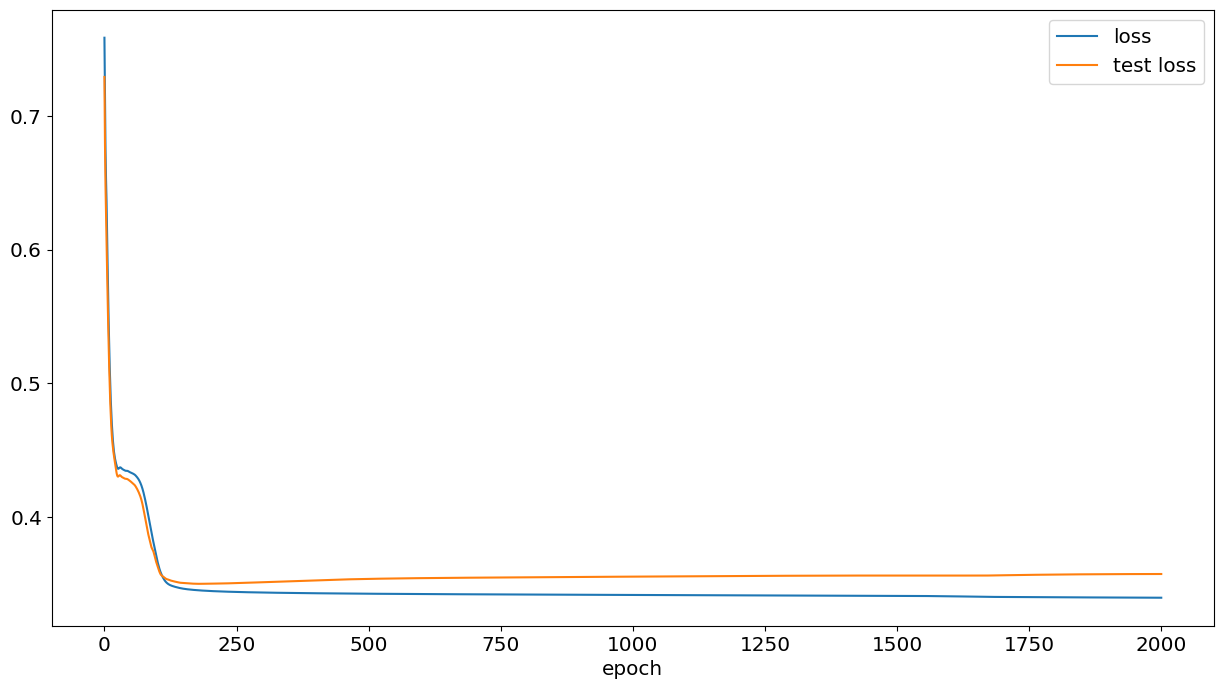

In [200]:
loss_df.plot(x="epoch", y=["loss", "test loss"])

<Axes: xlabel='epoch'>

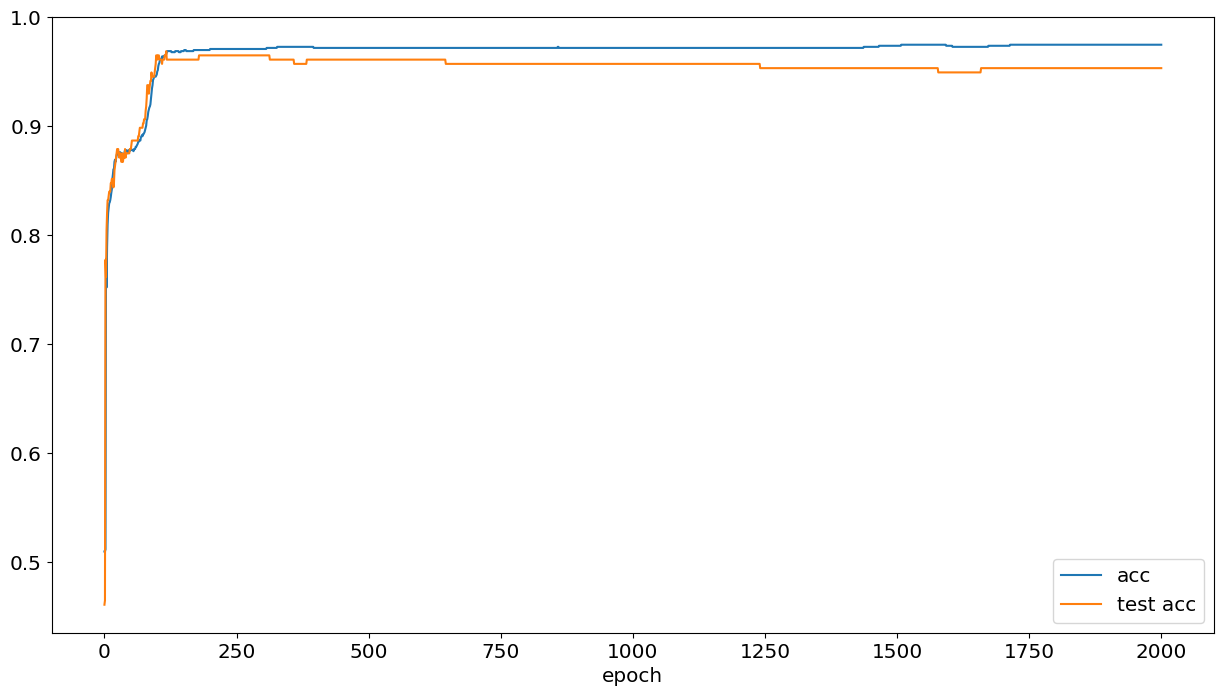

In [201]:
loss_df.plot(x="epoch", y=["acc", "test acc"])

In [202]:
pred_prob = model(test_X)
_, y_pred = torch.max(pred_prob, 1)

curr_acc_ts = accuracy_score(y_test.argmax(axis=1), y_pred.data.cpu())

print(f"Accuracy score on Test Data : {curr_acc_ts: .4f}")

Accuracy score on Test Data :  0.9531


In [203]:
y_pred = y_pred.cpu()
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       118
           1       0.97      0.94      0.96       138

    accuracy                           0.95       256
   macro avg       0.95      0.95      0.95       256
weighted avg       0.95      0.95      0.95       256



In [204]:
## Confusion Matrix helps

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred.cpu())
cm

array([[114,   4],
       [  8, 130]], dtype=int64)

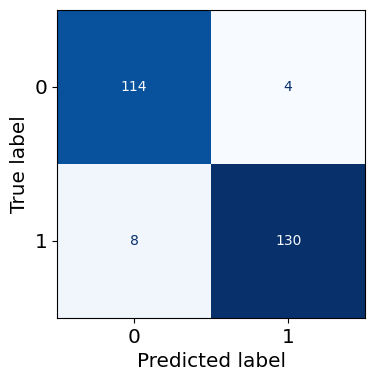

In [205]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

fig, ax = plt.subplots(figsize=(4, 4))

disp.plot(ax=ax, cmap="Blues", colorbar=False)

plt.show()